In [18]:
# pip install cvxpy pandas matplotlib tqdm

In [19]:
import cvxpy as cp
import pandas as pd
import numpy as np
import requests
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [20]:
time_from = pd.Timestamp("2026-02-24", tz="CET").floor("D")
time_to = time_from + pd.DateOffset(1)
idx = pd.date_range(start=time_from, end=time_to, freq="15min", inclusive="left")

In [21]:
# get day-ahead price (assume it is known)
time_from_str = time_from.tz_convert("UTC").strftime("%Y-%m-%dT%H:%M")
time_to_str = (time_to + pd.Timedelta("1h")).tz_convert("UTC").strftime("%Y-%m-%dT%H:%M")
price_area = "DK1"

url = f"https://api.energidataservice.dk/dataset/DayAheadPrices"
params = {
    "offset": 0,
    "start": time_from_str,
    "end": time_to_str,
}
res = requests.get(url, params=params)
res.raise_for_status()
price_df = pd.DataFrame(res.json().get("records")).query(f"PriceArea=='{price_area}'")
price_df.index = pd.to_datetime(price_df["TimeUTC"]).dt.tz_localize("UTC")
power_price = price_df["DayAheadPriceEUR"].astype(float).reindex(idx)

<Axes: >

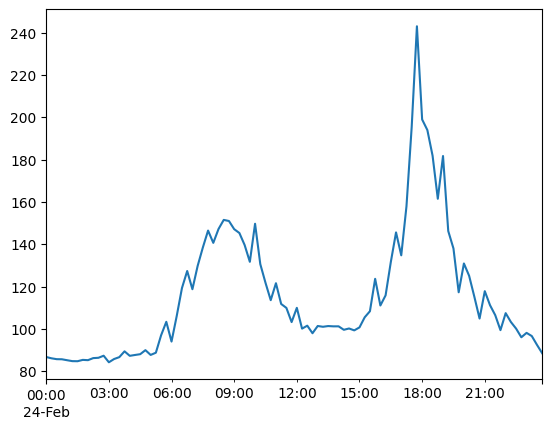

In [22]:
power_price.plot()

In [23]:
gb_eff = 0.98  # gas boiler heat efficiency
eb_eff = 0.98  # e-boiler heat efficiency
hp_cop = 4  # heat pump coefficient of performance
gas_price = 32  # EUR/MWht

heat_storage_capacity = 16800  # MWht

gb_capacity = 120  # MWt
hp_capacity = 80  # MWt
eb_capacity = 0  # MWt

max_power_cons = hp_capacity / hp_cop + eb_capacity / eb_eff

<Axes: >

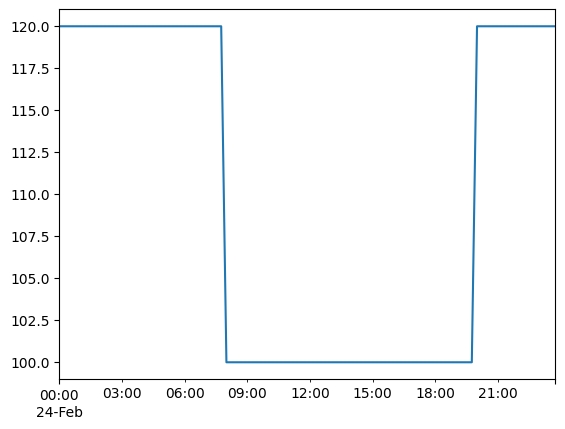

In [24]:
# heat demand is simulated to be higher during night time
heat_demand = pd.Series(100, index=idx)
heat_demand.loc[(heat_demand.index.hour >= 20) | (heat_demand.index.hour < 8)] = 120

heat_demand.plot()

In [25]:
# variables
hp_e_cons = cp.Variable(
    len(idx), name="hp_e_cons", nonneg=True
)  # heat pump electricity consumption
eb_e_cons = cp.Variable(
    len(idx), name="eb_e_cons", nonneg=True
)  # e boiler electricity consumption
gb_g_cons = cp.Variable(
    len(idx), name="gb_g_cons", nonneg=True
)  # gas boiler gas consumption

# parameters
up_regulation_cap = cp.Parameter(name="up_regulation_cap", value=0)
down_regulation_cap = cp.Parameter(name="down_regulation_cap", value=0)
up_regulation = cp.Parameter(len(idx), name="up_regulation", value=[max_power_cons] * len(idx))
down_regulation = cp.Parameter(len(idx), name="down_regulation", value=[0] * len(idx))

# auxiliary variables
total_e_cons = hp_e_cons + eb_e_cons
hp_h_prod = hp_e_cons * hp_cop
eb_h_prod = eb_eff * eb_e_cons
gb_h_prod = gb_eff * gb_g_cons
gas_cost = gas_price * gb_g_cons
power_cost = cp.multiply(power_price.values, hp_e_cons + eb_e_cons)
total_cost = power_cost + gas_cost

# constraints
constraints = [
    hp_h_prod + gb_h_prod + eb_h_prod == heat_demand.values,
    total_e_cons >= up_regulation_cap,
    total_e_cons <= up_regulation,
    total_e_cons >= down_regulation,
    max_power_cons - total_e_cons >= down_regulation_cap,
    hp_h_prod <= hp_capacity,
    gb_h_prod <= gb_capacity,
    eb_h_prod <= eb_capacity,
]

problem = cp.Problem(objective=cp.Minimize(cp.sum(total_cost)), constraints=constraints)
problem.solve()

np.float64(302782.9385338515)

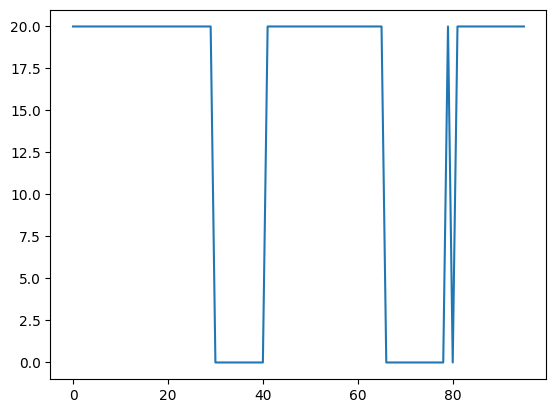

In [26]:
plt.plot(total_e_cons.value.round(4))

Change in cost: 439.12247130676406


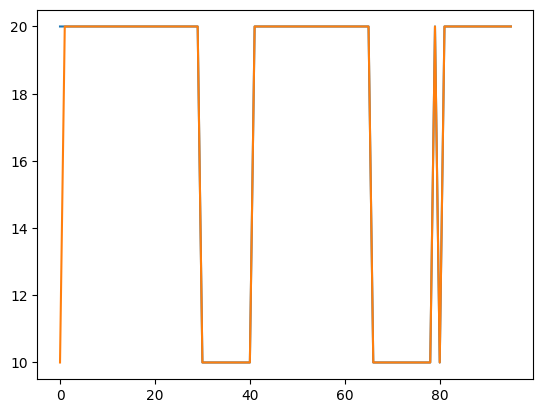

In [27]:
# example of up-regulation
up_regulation_cap.value = 10
up_regulation.value = [max_power_cons] * len(idx)

problem.solve()
total_cost_plan = problem.objective.value

plt.plot(total_e_cons.value.round(4), label="plan before activation")

up_regulation.value[0] = 10
problem.solve()
total_cost_new = problem.objective.value

plt.plot(total_e_cons.value.round(4), label="plan after activation")

print("Change in cost:", total_cost_new - total_cost_plan)


In [28]:
up_reg_bid_price = pd.Series()
for i in range(10, 20):
    up_regulation.value[0] = i
    problem.solve()
    up_reg_bid_price.loc[max_power_cons - i] = constraints[2].dual_value.round(4)[0]

<Axes: >

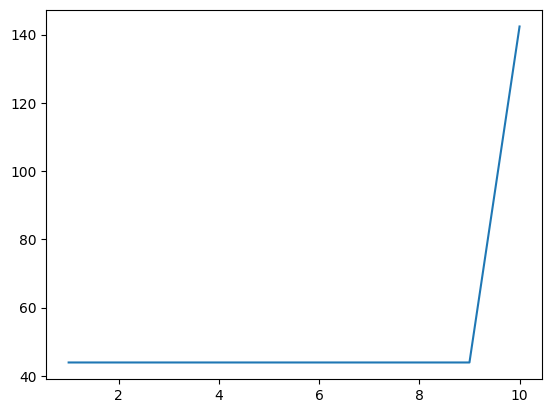

In [29]:
up_reg_bid_price.plot()

Change in cost: -21016.694350882142


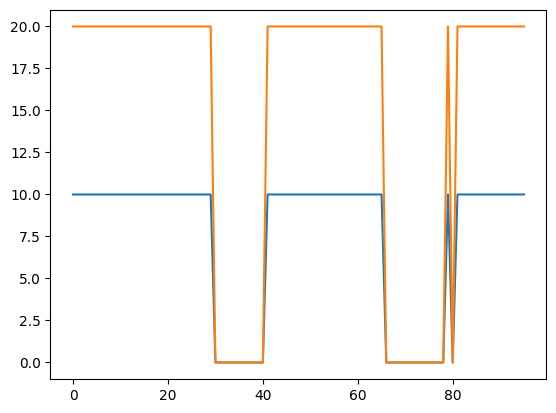

In [30]:
# example of down-regulation
up_regulation_cap.value = 0
up_regulation.value = [max_power_cons] * len(idx)
down_regulation_cap.value = 10
down_regulation.value = [0] * len(idx)

problem.solve()
total_cost_plan = problem.objective.value

plt.plot(total_e_cons.value.round(4), label="plan before activation")

down_regulation.value[0] = 9
down_regulation_cap.value = 0

problem.solve()
total_cost_new = problem.objective.value

plt.plot(total_e_cons.value.round(4), label="plan after activation")

print("Change in cost:", total_cost_new - total_cost_plan)
